<a href="https://colab.research.google.com/github/Bkra2020/YoloV5_PCB/blob/main/Copy_of_SAM_Elec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Gỡ numpy và transformers nếu có sẵn
!pip uninstall -y numpy transformers

# Xoá cache pip
!pip cache purge

# Cài lại numpy phiên bản tương thích và transformers stable
!pip install numpy==1.23.5
!pip install -q git+https://github.com/huggingface/transformers.git



Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: transformers 4.51.3
Uninstalling transformers-4.51.3:
  Successfully uninstalled transformers-4.51.3
Files removed: 0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 38.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.15.2 requires transformers, which is not installed.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
db-dtypes 1.4.3 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.

ERROR: Operation cancelled by user
^C


In [ ]:
# (Không nâng cấp numpy nữa! Vì sẽ lại gây lỗi '_center' như trước)
# Không chạy: !pip install --upgrade numpy

# Cài thinc (nếu bạn cần nó cho NLP, nhưng KHÔNG nên upgrade numpy theo sau)
!pip install thinc

# Segment Anything từ Meta AI
!pip install git+https://github.com/facebookresearch/segment-anything.git

# Datasets cho việc chuẩn bị data
!pip install datasets

# MONAI - cho medical loss functions
!pip install -q monai

# Patchify - chia ảnh lớn thành patches (nếu cần)
!pip install patchify

!pip clone https://github.com/Charmve/Surface-Defect-Detection.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 51.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.15.2 requires transformers, which is not installed.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-x3xcwgun
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-x3xcwgun
  Resolved https://github.com/fac

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage

In [ ]:
import os
import subprocess
import shutil

# Define repository URL and target folder
repo_url = "https://github.com/Charmve/Surface-Defect-Detection.git"
target_folder = "DeepPCB/PCBData"

# Clone the repository
print("Cloning repository...")
subprocess.run(["git", "clone", repo_url])

# Move the target dataset folder to the current directory
repo_name = repo_url.split("/")[-1].replace(".git", "")
source_path = os.path.join(repo_name, target_folder)
destination_path = os.path.basename(target_folder)

if os.path.exists(source_path):
    print(f"Moving dataset folder '{target_folder}'...")
    shutil.move(source_path, destination_path)
    print(f"Dataset downloaded successfully to '{destination_path}'.")
else:
    print("Dataset folder not found. Please check the repository structure.")

# Optional: Remove the cloned repository to clean up
shutil.rmtree(repo_name, ignore_errors=True)
print("Cleanup completed.")


Cloning repository...
Moving dataset folder 'DeepPCB/PCBData'...
Dataset downloaded successfully to 'PCBData'.
Cleanup completed.


In [ ]:
#165 large images as tiff image stack
# large_images = tifffile.imread("/content/training.tif")
# large_masks = tifffile.imread("/content/training_groundtruth.tif")
# large_images.shape


(165, 768, 1024)

#SAM

In [ ]:
#Desired patch size for smaller images and step size.
patch_size = 256
step = 256

all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

#Let us do the same for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)
images.shape


# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (1642, 256, 256)
Mask shape: (1642, 256, 256)


In [ ]:

from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

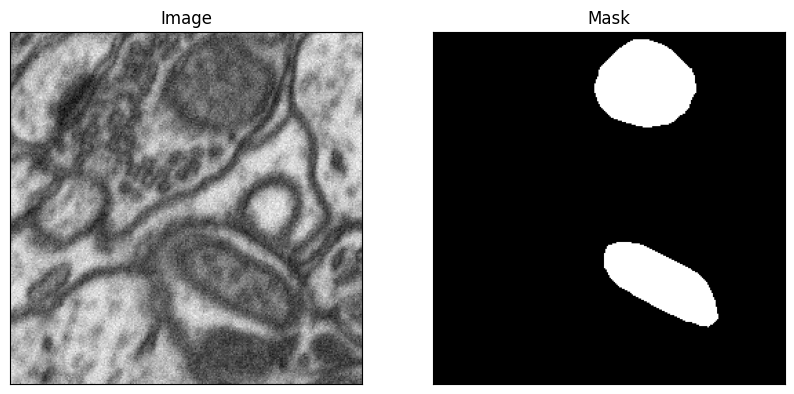

In [ ]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [ ]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [ ]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [ ]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)
batch["ground_truth_mask"].shape

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


torch.Size([2, 256, 256])

In [ ]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

100%|██████████| 821/821 [14:23<00:00,  1.05s/it]


EPOCH: 0
Mean loss: 0.2020735551719979


100%|██████████| 821/821 [14:27<00:00,  1.06s/it]


EPOCH: 1
Mean loss: 0.13233619328048285


100%|██████████| 821/821 [14:28<00:00,  1.06s/it]


EPOCH: 2
Mean loss: 0.11633626689247324


100%|██████████| 821/821 [14:30<00:00,  1.06s/it]


EPOCH: 3
Mean loss: 0.11017761141034557


100%|██████████| 821/821 [14:29<00:00,  1.06s/it]


EPOCH: 4
Mean loss: 0.10468160716338076


100%|██████████| 821/821 [14:28<00:00,  1.06s/it]


EPOCH: 5
Mean loss: 0.0985082627095999


100%|██████████| 821/821 [14:27<00:00,  1.06s/it]


EPOCH: 6
Mean loss: 0.09593057144664673


100%|██████████| 821/821 [14:27<00:00,  1.06s/it]


EPOCH: 7
Mean loss: 0.09258717626342312


100%|██████████| 821/821 [14:29<00:00,  1.06s/it]


EPOCH: 8
Mean loss: 0.09002873054212107


100%|██████████| 821/821 [14:26<00:00,  1.06s/it]

EPOCH: 9
Mean loss: 0.08650848553737174


In [ ]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "/content/model.pth")

In [ ]:

from transformers import SamModel, SamConfig, SamProcessor
import torch
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("/content/model.pth")

#YOLO fault PCB detect

In [ ]:
!git clone https://github.com/MBDNotes/YOLOv5_PCB_Defects_Detection.git
!pip install declxml


Cloning into 'YOLOv5_PCB_Defects_Detection'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (2/2), done.
remote: Total 7 (delta 1), reused 1 (delta 1), pack-reused 5 (from 1)
Receiving objects: 100% (7/7), 10.88 KiB | 10.88 MiB/s, done.
Resolving deltas: 100% (1/1), done.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for declxml: filename=declxml-1.1.3-py3-none-any.whl size=12279 sha256=0524fd18525afaf979d8cb92acb810d97ef3a6f0a181adcf3406a11df2b8de7e
  Stored in directory: /root/.cache/pip/wheels/b1/8c/f6/cf019ee4bf063347dea4e12935502ecbc65e484cc466a60c7d
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26304 sha256=2296a84cfecf6a94b056b28fa792255cdb7a5f278d2d82da4812622c7499c355
  Stored in directory: /root/.cache/pip/wheels/9d/67/2f/53e3ef32ec48d11d7d60245255e2d71e908201d20c880c08ee
Successfully built decl

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("akhatova/pcb-defects")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/pcb-defects


In [ ]:
import os
os.chdir("/content/XmlToTxt")
!python xmltotxt.py -c classes.txt -xml xml -out out
'''copy nội dung dưới vô file classes.txt:
missing_hole
mouse_bite
open_circuit
short
spur
spurious_copper
'''


In [ ]:
# prompt: mout the XmlToTxt into My drive
from google.colab import drive
drive.mount('/content/drive')
!mv /content/XmlToTxt "/content/drive/My Drive/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from random import choice
import shutil
def to_v5_directories(images_train_path,images_val_path,labels_train_path,labels_val_path, dataset_source):
    imgs =[]
    xmls =[]
    trainPath = images_train_path
    valPath =  images_val_path
    crsPath = dataset_source
    train_ratio = 0.8
    val_ratio = 0.2
    totalImgCount = len(os.listdir(crsPath))/2
    for (dirname, dirs, files) in os.walk(crsPath):
        for filename in files:
            if filename.endswith('.txt'):
                xmls.append(filename)
            else:
                imgs.append(filename)
    countForTrain = int(len(imgs)*train_ratio)
    countForVal = int(len(imgs)*val_ratio)
    trainimagePath = images_train_path
    trainlabelPath = labels_train_path
    valimagePath = images_val_path
    vallabelPath = labels_val_path
    for x in range(countForTrain):
        fileJpg = choice(imgs)
        fileXml = fileJpg[:-4] +'.txt'
        shutil.copy(os.path.join(crsPath, fileJpg), os.path.join(trainimagePath, fileJpg))
        shutil.copy(os.path.join(crsPath, fileXml), os.path.join(trainlabelPath, fileXml))
        imgs.remove(fileJpg)
        xmls.remove(fileXml)
    for x in range(countForVal):
        fileJpg = choice(imgs)
        fileXml = fileJpg[:-4] +'.txt'
        shutil.copy(os.path.join(crsPath, fileJpg), os.path.join(valimagePath, fileJpg))
        shutil.copy(os.path.join(crsPath, fileXml), os.path.join(vallabelPath, fileXml))
        imgs.remove(fileJpg)
        xmls.remove(fileXml)
    print("Training images are : ",countForTrain)
    print("Validation images are : ",countForVal)

In [ ]:
os.chdir("/content")
to_v5_directories("/content/Dataset/images/train","/content/Dataset/images/val","/content/Dataset/labels/train","/content/Dataset/labels/val", "/content/drive/MyDrive/XmlToTxt/out/Missing_hole")
to_v5_directories("/content/Dataset/images/train","/content/Dataset/images/val","/content/Dataset/labels/train","/content/Dataset/labels/val", "/content/drive/MyDrive/XmlToTxt/out/Mouse_bite")
to_v5_directories("/content/Dataset/images/train","/content/Dataset/images/val","/content/Dataset/labels/train","/content/Dataset/labels/val", "/content/drive/MyDrive/XmlToTxt/out/Open_circuit")
to_v5_directories("/content/Dataset/images/train","/content/Dataset/images/val","/content/Dataset/labels/train","/content/Dataset/labels/val", "/content/drive/MyDrive/XmlToTxt/out/Short")
to_v5_directories("/content/Dataset/images/train","/content/Dataset/images/val","/content/Dataset/labels/train","/content/Dataset/labels/val", "/content/drive/MyDrive/XmlToTxt/out/Spur")
to_v5_directories("/content/Dataset/images/train","/content/Dataset/images/val","/content/Dataset/labels/train","/content/Dataset/labels/val", "/content/drive/MyDrive/XmlToTxt/out/Spurious_copper")

Training images are :  92
Validation images are :  23
Training images are :  92
Validation images are :  23
Training images are :  92
Validation images are :  23
Training images are :  92
Validation images are :  23
Training images are :  92
Validation images are :  23
Training images are :  92
Validation images are :  23


In [ ]:
!git clone https://github.com/ultralytics/yolov5.git

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [ ]:
!pip install -r /content/yolov5/requirements.txt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.2 MB/s eta 0:00:00


In [ ]:
!python /content/yolov5/train.py --img 416 --batch 32 --epochs 100 --data /content/YOLOv5_PCB_Defects_Detection/dataset.yaml --weights yolov5s.pt --cache --name pcb_1st

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-05-22 03:57:10.907011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747886230.944283   25571 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747886230.955116   25571 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5s.pt, cfg=, data=/content/YOLOv5_PCB_Defects_Detection/da

In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

def run_yolo_inference(image_path, model_weights_path, img_size=416, conf_thres=0.25):
    """
    Dự đoán và hiển thị ảnh đầu ra sau khi chạy inference bằng YOLOv5.

    Args:
        image_path (str): Đường dẫn ảnh đầu vào.
        model_weights_path (str): Đường dẫn đến file .pt model đã huấn luyện.
        img_size (int): Kích thước ảnh (phù hợp với lúc train, vd: 416).
        conf_thres (float): Ngưỡng confidence để lọc kết quả.
    """

    # Load model
    model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_weights_path, force_reload=True)
    model.conf = conf_thres
    model.iou = 0.45
    model.imgsz = img_size

    # Run inference
    results = model(image_path)

    # Hiển thị kết quả
    results.show()

    # (Tuỳ chọn) Lưu ảnh kết quả
    results.save(save_dir='inference_result')

    print(f"[✓] Đã lưu ảnh kết quả tại thư mục: inference_result/")
image_path = '/content/test_image.jpg'
model_path = '/content/runs/train/pcb_1st/weights/best.pt'

run_yolo_inference(image_path, model_path)
